In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
from scipy.io import loadmat
import random
import copy
import os
from matplotlib.pyplot import imread
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image

import numpy as np
##make sure that all dataset has been downloaded in to path:
path = './drive/MyDrive/Colab Notebooks/car_classification/data/'
#!cp -rf /content/drive/My\ Drive/Colab\ Notebooks/car_ims.tgz ./


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#! wget http://imagenet.stanford.edu/internal/car196/cars_train.tgz
# ! wget http://imagenet.stanford.edu/internal/car196/cars_test.tgz
#! wget http://imagenet.stanford.edu/internal/car196/cars_annos.mat
# ! tar -zxvf ./drive/MyDrive/Colab\ Notebooks/car_classification/data/car_ims.tgz
data = loadmat(os.path.join(path,  'cars_annos.mat'))
annotations = data["annotations"][0,:]
nclass = len(data["class_names"][0])
print(nclass)
#/content/drive/MyDrive/Colab Notebooks/car_classification/data/cars_annos.mat

196


In [ ]:
## Task 1 - Build a function that converts a labelled dataset into labelled and unlabelled subsets.
def convert_labelled(label, rate):
    label_ori = copy.deepcopy(label)
    unlabel = []
    for c in range(nclass):
        subl = [i  for i in range(len(label)) if label[i] == c+1]
        num = int(len(subl) * rate)
        random.seed(30)
        unlabel  += random.sample(subl, num)
    #for i in unlabel:
        #label[i] = 'nan'
    
    remain = set(list(range(len(label)))) - set(unlabel)
        
    return sorted(list(remain)), sorted(unlabel)
    

In [ ]:

## Task 2 - Data cleaning
def remove_image():
    for i in range(len(annotations)):
            f_path = annotations[i][0][-1]
            f_name = os.path.join(path, f_path)
            
            image = imread(f_name)
            if len(image.shape) < 3:
                os.remove(f_name)
                print('remove non RGB image: {}'.format(f_name))
## remove all images which are not RBG
remove_image()   



remove non RGB image: ./drive/MyDrive/Colab Notebooks/car_classification/data/car_ims/000050.jpg
remove non RGB image: ./drive/MyDrive/Colab Notebooks/car_classification/data/car_ims/001053.jpg
remove non RGB image: ./drive/MyDrive/Colab Notebooks/car_classification/data/car_ims/001225.jpg
remove non RGB image: ./drive/MyDrive/Colab Notebooks/car_classification/data/car_ims/001257.jpg
remove non RGB image: ./drive/MyDrive/Colab Notebooks/car_classification/data/car_ims/001265.jpg
remove non RGB image: ./drive/MyDrive/Colab Notebooks/car_classification/data/car_ims/001269.jpg
remove non RGB image: ./drive/MyDrive/Colab Notebooks/car_classification/data/car_ims/001270.jpg
remove non RGB image: ./drive/MyDrive/Colab Notebooks/car_classification/data/car_ims/001287.jpg
remove non RGB image: ./drive/MyDrive/Colab Notebooks/car_classification/data/car_ims/001301.jpg
remove non RGB image: ./drive/MyDrive/Colab Notebooks/car_classification/data/car_ims/001302.jpg
remove non RGB image: ./drive/

In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [ ]:
##Task 3 - Dataset representation

scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

In [ ]:
##prtrained model
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
print("number of features: ", num_ftrs)
#model_ft.fc = nn.Linear(num_ftrs, 1000)
model_ft.fc = nn.Identity()
# Use the model object to select the desired layer
layer = model_ft._modules.get('avgpool')
# Set model to evaluation mode
model_ft.eval()
#model_ft = model_ft.to(device)
#criterion = nn.CrossEntropyLoss()  #(set loss function)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
## select features by loading image in pretained model
def select_feateure(image_name):
    #Load the image 
    img = Image.open(image_name).convert('RGB')
    # Create a PyTorch Variable with the transformed image
    t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))
    # Create a vector of zeros that will hold our feature vector
    # The 'avgpool' layer has an output size of 512
    embedding = torch.zeros(512)
    # Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        embedding.copy_(o.data.reshape(o.data.size(1)))
    # Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)
    # Run the model on our transformed image
    model_ft(t_img)
    # Detach our copy function from the layer
    h.remove()
    # Return the feature vector
    return embedding

# f_name = os.path.join(path, 'car_ims' , '000001.jpg') 
# pic_one_vector = select_feateure(f_name)
# print(pic_one_vector)

In [ ]:
filenames = [name for name in os.listdir(os.path.join(path, 'car_ims')  )]
filenames.sort()
len(filenames)
cleaned_images = {}
for i, name in enumerate(filenames):
  f_name = os.path.join(path, 'car_ims' , name) 
  
  img_feature = select_feateure(f_name)
  feature_array = img_feature.detach().cpu().numpy()
  clas_idx =  data["annotations"][0][int(name[:-4])-1][-2][0][0]  
  cleaned_images[i] = {'embedding':feature_array , 'class_idx': clas_idx , 'labelled': 1}


In [ ]:
print(len(cleaned_images))
print(cleaned_images[1])

16151
{'embedding': array([1.05518472e+00, 1.39776960e-01, 4.43138629e-01, 1.02861533e-02,
       3.20197535e+00, 2.59982497e-01, 1.70399678e+00, 9.98326123e-01,
       7.06356049e-01, 2.10560012e+00, 5.60688257e-01, 3.84638727e-01,
       1.16460390e-01, 3.98767257e+00, 4.26055998e-01, 8.71467352e-01,
       3.89604479e-01, 1.04362071e+00, 3.89927834e-01, 1.18320835e+00,
       6.97513282e-01, 2.01150107e+00, 6.88045800e-01, 5.17460823e-01,
       5.27184010e-01, 8.45532715e-01, 1.10788667e+00, 3.36046529e+00,
       2.40412503e-01, 5.37027836e-01, 6.56465590e-01, 3.40388119e-01,
       3.60626072e-01, 1.14849225e-01, 5.80681443e-01, 2.45095506e-01,
       6.28971159e-02, 9.47508216e-01, 4.29433912e-01, 5.16697645e-01,
       3.41747046e-01, 1.91562921e-01, 2.85744250e-01, 1.91122723e+00,
       3.65263402e-01, 5.87281764e-01, 7.60145664e-01, 4.60109591e-01,
       4.23128217e-01, 1.06324947e+00, 2.07030845e+00, 5.66605568e-01,
       2.46366501e+00, 2.85364032e-01, 5.48644364e-01, 1.

In [ ]:
##save dictionary to disc
torch.save(cleaned_images, os.path.join(path, 'tensor_img2.pt'))

In [ ]:
## TASK 4 - Build a partially labelled dataset
## Using the function from Task 1, and the processed dataset from Task 3, create
## a dataset with only 40% of the data being labelled, and 60% unlabelled.

# reload dataset from task 3
dataset = torch.load(os.path.join(path, 'tensor_img2.pt'))
dataset_label = [dataset[i]['class_idx']  for i in range(len(dataset))]
print(max(dataset_label))
# remove label based on unlabel data rate = 0.6
label_idx, unlabel_idx = convert_labelled(dataset_label, 0.6)

# create label and unlabel datasets
label_data = [dataset[i] for i in label_idx]
unlabel_data = [dataset[i] for i in unlabel_idx]


196


In [ ]:
## TASK 5 - Create train/validation split
# input:  takes two arguments, dataset_inputs and dataset_labels, and a float 
# between [0,1], “training_proportion”
# output:  The function returns 4 objects, training_inputs, training_labels, 
# test_inputs, test_labels.

def train_validation(input_data, split_rate):
    
    df = pd.DataFrame(columns=["embedding","class_idx","labelled"])
    for i in range(len(input_data)):
        x, y, z = input_data[i]["embedding"], int(input_data[i]["class_idx"]), input_data[i]["labelled"]
        df = df.append({"embedding" : x ,"class_idx": y,"labelled": z}, ignore_index=True)
    l = []
    for i in df["embedding"]:
      l.append(list(i))
    
    x_train, x_test, y_train, y_test = train_test_split(np.array(l), 
                                    df["class_idx"].to_list(), random_state=1,
                                    train_size = split_rate)
    
    return x_train, x_test, list(y_train), list(y_test) 
    ##training_inputs, test_inputs, training_labels, test_labels


#x_train, x_test, y_train, y_test = train_validation(label_data, 0.6)



In [ ]:
## TASK 6 - Create experiment(s) to convince clients that more labelled data will improve model
## performance

#use a simple linear model using the embeddings as your inputs using sklearn.
#linear_model.SGDClassifier. Use whatever number of iterations it takes to train
#a model in 1 minute MAX (don't worry, we aren't judging results based on accuracy).
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import scale
from sklearn import metrics
from sklearn.calibration import CalibratedClassifierCV
from scipy.stats import entropy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
## prove more labeled dataset is helpful to predict
train_props = [0.1, 0.3, 0.5, 0.7]
accuracies = []
for prop in train_props:
    # split data
    print("spliting dataset with {} unlabeled dataset".format(str(prop)))
    x_train, x_test, y_train, y_test = train_validation(label_data, prop)
    
    #initiate linear classifier
    sgdc = SGDClassifier(max_iter=1000, tol=0.01)
    #print(sgdc)
    sgdc.fit(x_train, y_train) 

    score = sgdc.score(x_train, y_train)
    print("Training score: ", score) 
    
    #apply fit model on test label dataset
    ypred = sgdc.predict(x_test)
    # confusion matrix
    cm = confusion_matrix(y_test, ypred)
    #print(cm) 
    # evaluation report
    cr = classification_report(y_test, ypred)
    #print(cr)
    accuracy = metrics.accuracy_score(y_test, ypred)
    accuracies.append(accuracy)



spliting dataset with 0.1 unlabeled dataset
Training score:  0.9877488514548239
spliting dataset with 0.3 unlabeled dataset


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training score:  0.898521162672106
spliting dataset with 0.5 unlabeled dataset


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training score:  0.9011627906976745
spliting dataset with 0.7 unlabeled dataset


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training score:  0.8926775956284153
spliting dataset with 0.9 unlabeled dataset


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training score:  0.7378888322284549


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1

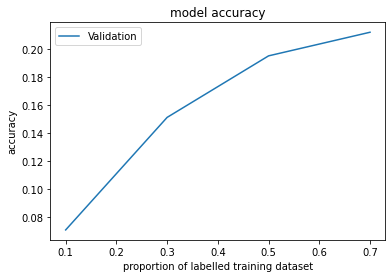

In [ ]:
#accuracies

plt.plot(train_props, accuracies)

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('proportion of labelled training dataset')
plt.legend(['Validation'], loc='upper left')
plt.show()

In [ ]:
## TASK 7 - Active learning to select new instances to be labelled
## Your clients have agreed to label an additional 25% of the dataset (to a 
## total of 65% of the original dataset).

# reload dataset from task 3
dataset = torch.load(os.path.join(path, 'tensor_img2.pt'))
dataset_label = [dataset[i]['class_idx']  for i in range(len(dataset))]
print(max(dataset_label))
# remove label based on unlabel data rate = 0.6
label_idx, unlabel_idx = convert_labelled(dataset_label, 0.6)

# create label and unlabel datasets
label_data = [dataset[i] for i in label_idx]
unlabel_data = [dataset[i] for i in unlabel_idx]


196


In [ ]:
print(len(unlabel_data))
print(unlabel_data[0])

9614
{'embedding': array([0.8994566 , 1.0016916 , 0.8916858 , 0.62271315, 2.508561  ,
       0.21982332, 1.4202434 , 1.951679  , 0.23703796, 0.50243634,
       1.3036352 , 0.47396147, 0.6457658 , 2.0849724 , 0.4292592 ,
       1.3479486 , 0.31240988, 0.6330183 , 2.0694659 , 2.911168  ,
       0.77041376, 0.38907167, 1.9509757 , 2.852985  , 0.88672894,
       0.16412424, 1.386724  , 2.208711  , 0.14938061, 0.5428319 ,
       1.1996477 , 0.48549643, 0.9042489 , 0.26615772, 1.272459  ,
       0.93370235, 1.0015212 , 1.1426759 , 0.08331454, 1.1876007 ,
       0.723631  , 0.03145596, 0.1263955 , 0.34816703, 0.5255119 ,
       0.39935723, 1.4404399 , 0.3327963 , 1.2484539 , 0.4020178 ,
       2.9776185 , 2.2223763 , 1.9777588 , 1.0938836 , 0.83923084,
       0.05363775, 1.8844789 , 0.24401468, 1.4689387 , 0.28241387,
       0.0814588 , 0.25172067, 1.287622  , 0.22444515, 0.64113086,
       0.28485376, 0.6349713 , 0.26864335, 0.1505473 , 0.04138414,
       0.7905487 , 1.4631354 , 0.7751816 , 

In [ ]:
##Using the model trained on 40% of the data and the unlabelled inputs, use 
##predict_proba function of your sklearn.linear_model.SGDClassifier model to 
##get the probability scores for each class on your unlabelled instances. 
##Use from scipy.stats entropy to compute the entropy of the predictions for 
##the unlabelled instances. Select the K instances with the highest entropy for
##labelling, where K is the remaining number of instances that will bring your 
##total labelled dataset to 65%. This will be added to the labelled subset and
##will be your ‘final’ dataset.


#initiate linear classifier
sgdc = SGDClassifier(max_iter=1000, tol=0.01)
print(sgdc)
clf = sgdc.fit(x_train, y_train) 
calibrator = CalibratedClassifierCV(clf, cv='prefit')
model=calibrator.fit(x_train, y_train)


SGDClassifier(tol=0.01)


In [ ]:

df = pd.DataFrame(columns=["embedding","class_idx","labelled"])
for i in range(len(unlabel_data)):
      x, y, z = unlabel_data[i]["embedding"], int(unlabel_data[i]["class_idx"]), unlabel_data[i]["labelled"]
      df = df.append({"embedding" : x ,"class_idx": y,"labelled": z}, ignore_index=True)
x_train_unl = []
for i in df["embedding"]:
    x_train_unl.append(list(i))
x_train_unl = np.array(x_train_unl)
y_train_unl = df["class_idx"].to_list()

In [ ]:
probs = model.predict_proba(x_train_unl)

In [ ]:
entro = []
for i in range(len(probs)):
    entro.append((entropy(probs[i]), i))

entro.sort(reverse=True)
#add k unlabelled instances

k = int(len(dataset) * 0.25)
add_label = entro[0:k]
for e, idx in add_label:
    label_data.append(dataset[idx])

##now the proportion of  total labelled dataset is 65%

In [ ]:
## TASK 8 - Final model training and evaluation

# 1. Using your training dataset, train a final model and then use it to evaluate
# your model on your hold out validation dataset.
x_train, x_test, y_train, y_test = train_validation(label_data, 0.7)

In [89]:
from sklearn.svm import SVC
#{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} 
train_props = [0.5, 0.7, 0.85, 0.95, 0.98]
accuracies, train_score = [], [ ]
for prop in train_props:
    # split data
    print("spliting dataset with {} unlabeled dataset".format(str(prop)))
    x_train, x_test, y_train, y_test = train_validation(label_data, prop)
    
    svm = SVC(gamma='scale', C=0.1,kernel='poly', random_state=101)
    svm.fit(x_train,y_train)
    accuracies.append(svm.score(x_test, y_test))
    train_score.append(svm.score(x_train, y_train))

spliting dataset with 0.5 unlabeled dataset
spliting dataset with 0.7 unlabeled dataset
spliting dataset with 0.85 unlabeled dataset
spliting dataset with 0.95 unlabeled dataset
spliting dataset with 0.98 unlabeled dataset


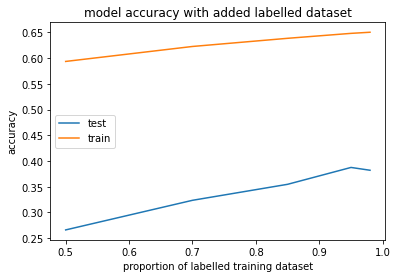

In [95]:
#accuracies
#train_score
#accuracies

plt.plot(train_props, accuracies)
plt.plot(train_props, train_score)
plt.title('learning curve with added labelled dataset')
plt.ylabel('accuracy')
plt.xlabel('training dataset size')
plt.legend(['test', 'train'], loc='center left')
plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


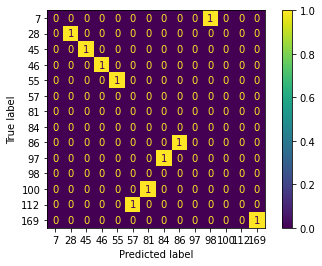

In [103]:
#test_pred = svm.predict(x_test)
#metrics.plot_confusion_matrix(svm, x_test[0:10], y_test[0:10])  
#plt.show()